In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
num_classes = 10
input_shape = (32 , 32 , 3)

(x_train , y_train) , (x_test , y_test) = keras.datasets.cifar10.load_data()

print(f"X_train_shape : {x_train.shape}  ----   Y_train_shape : {y_train.shape}")
print(f"X_test_shape : {x_test.shape}  ----   Y_test_shape : {y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
X_train_shape : (50000, 32, 32, 3)  ----   Y_train_shape : (50000, 1)
X_test_shape : (10000, 32, 32, 3)  ----   Y_test_shape : (10000, 1)


In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 40
image_size = 72
patch_size = 6
num_heads = 4
num_patches = (image_size // patch_size)**2
projection_dim = 64
transformer_units = [
    projection_dim * 2 ,
    projection_dim
]

transformer_layers = 8
mlp_head_units = [2048 , 1024]

In [4]:
data_augmentation = keras.Sequential([
    layers.Normalization() ,
    layers.Resizing(image_size , image_size) ,
    layers.RandomFlip("horizontal") ,
    layers.RandomRotation(factor = 0.02) ,
    layers.RandomZoom(
        height_factor = 0.2 , width_factor = 0.2
    )] ,
    name = "data_augmentation"
)

data_augmentation.layers[0].adapt(x_train)

In [5]:
def mlp(x , hidden_units , dropout_rate = 0.0):
    for units in hidden_units:
        x = layers.Dense(units , activation = tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 x 72
Patch size: 6 x 6
Patches per image: 144
Elements per patch: 108


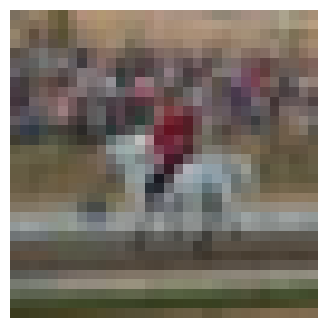

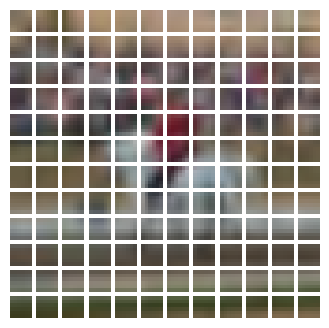

In [7]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

# Resize the image to the desired input size for the ViT model
resized_image = tf.image.resize(tf.convert_to_tensor([image]), size=(image_size, image_size))

# Create an instance of the Patches class and generate patches
patches_layer = Patches(patch_size)
patches = patches_layer(resized_image)

# Display patch information
print(f"Image size: {image_size} x {image_size}")
print(f"Patch size: {patch_size} x {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

# Display the patches
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

plt.show()

In [8]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projections = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        position = tf.range(start=0, limit=self.num_patches, delta=1)
        # Correcting the attribute reference and using position instead of positions
        encoded = self.projections(patch) + self.position_embedding(position)
        return encoded

In [9]:
def create_vit_classification():
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes)(features)
    model = keras.Model(inputs=inputs, outputs=logits)

    return model

In [10]:
def run_model(model):
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="Top_5_accuracy"),
        ],
    )

    checkpoint_filepath = "./tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback]
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, Top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy : {round(accuracy * 100, 2)}%")
    print(f"Top_5_accuracy : {round(Top_5_accuracy * 100, 2)}%")

In [11]:
vit_classifier = create_vit_classification()
history = run_model(vit_classifier)

Epoch 1/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 104s 405ms/step - Top_5_accuracy: 0.7435 - accuracy: 0.2518 - loss: 2.6615 - val_Top_5_accuracy: 0.9096 - val_accuracy: 0.4554 - val_loss: 1.5288
Epoch 2/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 80s 421ms/step - Top_5_accuracy: 0.8904 - accuracy: 0.4249 - loss: 1.6095 - val_Top_5_accuracy: 0.9392 - val_accuracy: 0.5398 - val_loss: 1.2765
Epoch 3/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 74s 419ms/step - Top_5_accuracy: 0.9233 - accuracy: 0.4879 - loss: 1.4195 - val_Top_5_accuracy: 0.9544 - val_accuracy: 0.5800 - val_loss: 1.1752
Epoch 4/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 84s 432ms/step - Top_5_accuracy: 0.9362 - accuracy: 0.5251 - loss: 1.3229 - val_Top_5_accuracy: 0.9586 - val_accuracy: 0.6048 - val_loss: 1.1140
Epoch 5/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 92s 492ms/step - Top_5_accuracy: 0.9452 - accuracy: 0.5579 - loss: 1.2472 - val_Top_5_accuracy: 0.9680 - val_accuracy: 0.6480 - val_loss: 1.0232
Epoch 6/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 135s 454ms/step - Top_5_accuracy: 